In [22]:
import pandas as pd
import numpy as np
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.datasets import load_iris
import seaborn as sns

import matplotlib.pyplot as plt
sns.set()

In [3]:
iris=load_iris()

In [4]:
x=iris['data']
y=iris['target']

In [208]:
n1=np.random.normal(0,1,(100,2))
n2=np.random.normal(2,1,(100,2))
n=np.concatenate([n1,n2],axis=0)

In [209]:
yr=np.concatenate([np.ones(100),-1*np.ones(100)],axis=0)

In [210]:
data=np.concatenate([n,yr.reshape(-1,1)],axis=1)
data=pd.DataFrame(data=data, columns=['x','y','target'])

In [211]:
data.target=data['target'].astype('long')

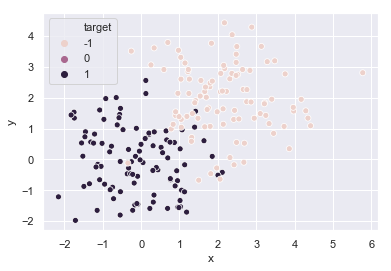

In [60]:
sns.scatterplot(data=data,x='x',y='y',hue='target')

# SKlearn classifier

In [134]:
Ada=AdaBoostClassifier(n_estimators=5,algorithm='SAMME')

In [135]:
Ada.fit(n,yr)

AdaBoostClassifier(algorithm='SAMME', n_estimators=5)

In [136]:
ypred=Ada.predict(n)

In [137]:
accuracy_score(ypred,yr)

0.915

## Decision boundary

In [178]:
def decision_plot(X,model,ax=None):
    plot_step=0.02
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))

    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    if ax is not None:
        cs = ax.contourf(xx, yy, Z, cmap=plt.cm.Pastel1)
    else:
        cs = plt.contourf(xx, yy, Z, cmap=plt.cm.Pastel1)

In [212]:
Ada=AdaBoostClassifier(n_estimators=6,algorithm='SAMME')
Ada.fit(n,yr)

AdaBoostClassifier(algorithm='SAMME', n_estimators=6)

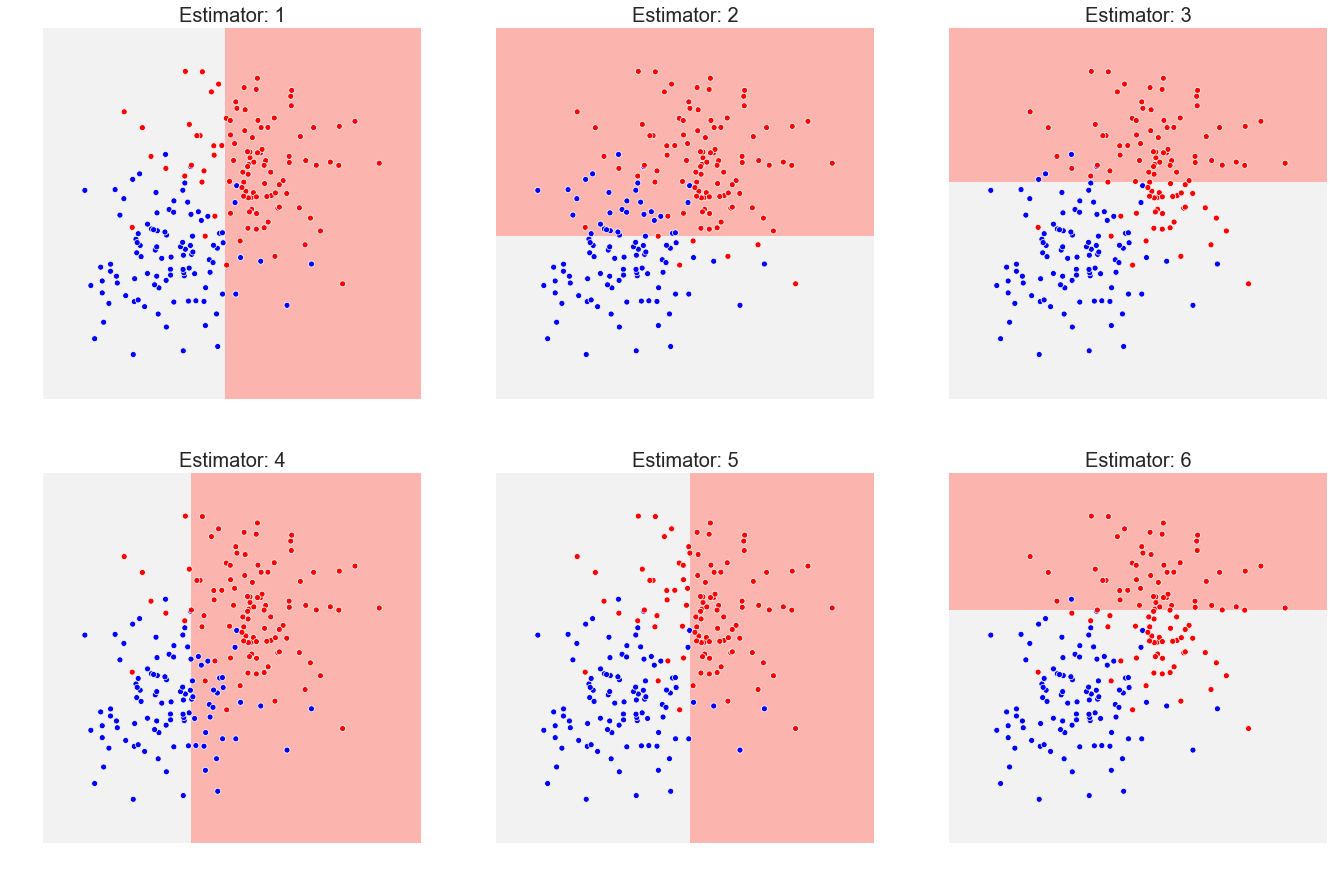

In [213]:
fig, axes=plt.subplots(2,3,figsize=(23,15))
for i in range(2):
    for j in range(3):
        decision_plot(n,Ada.estimators_[j+3*i],axes[i,j])
        sns.scatterplot(ax=axes[i,j],data=data,x='x',y='y',hue='target',legend=False,palette=['red','blue'])
        axes[i,j].set_title("Estimator: "+str(j+1+3*i),fontsize=20)
        axes[i,j].axis('off')
plt.savefig('../joaomvg.github.io/content/images/adaboost5.png')
plt.show()

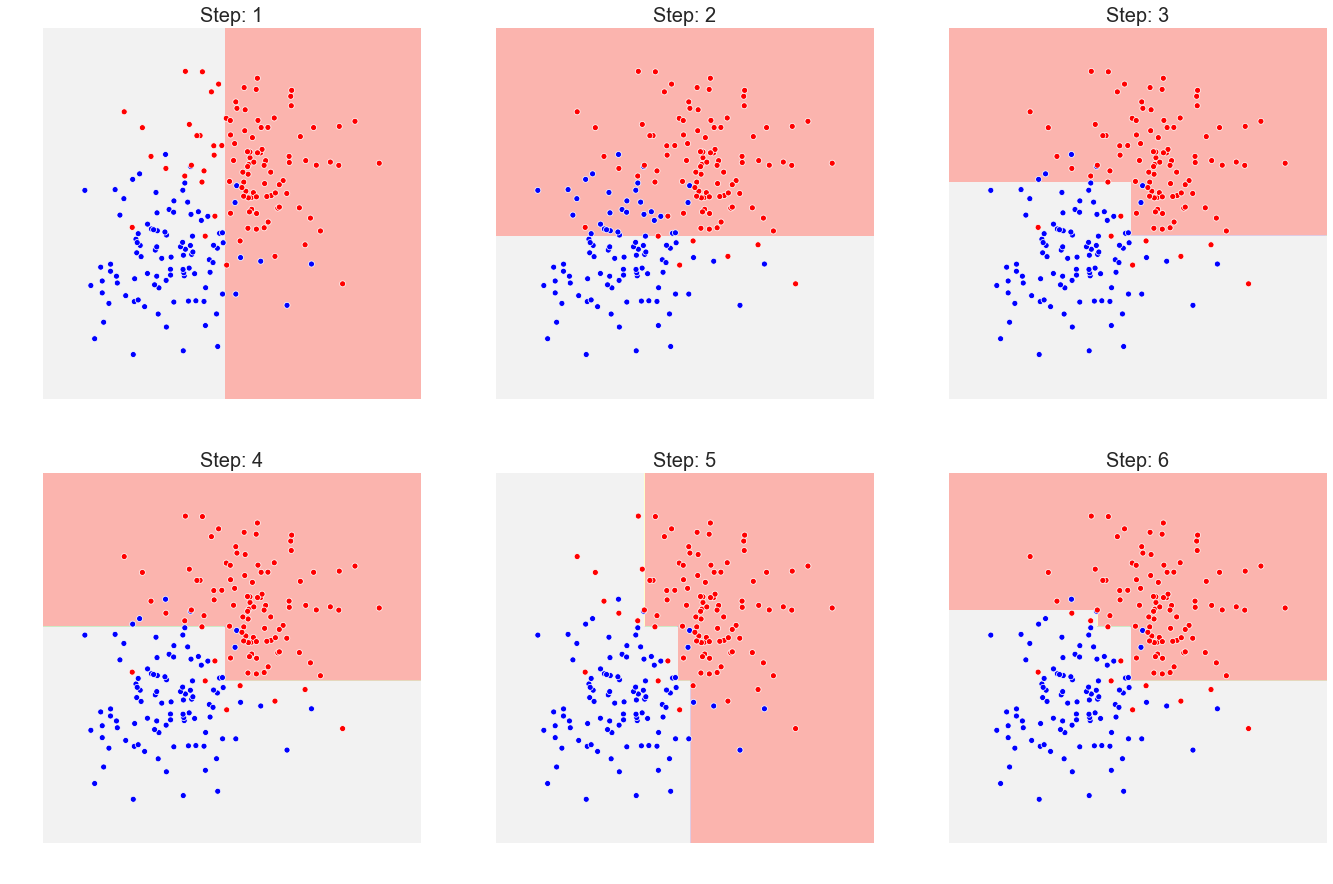

In [214]:
fig, axes=plt.subplots(2,3,figsize=(23,15))
for i in range(2):
    for j in range(3):
        Ada=AdaBoostClassifier(n_estimators=j+1+3*i,algorithm='SAMME')
        Ada.fit(n,yr)
        decision_plot(n,Ada,axes[i,j])
        sns.scatterplot(ax=axes[i,j],data=data,x='x',y='y',hue='target',legend=False,palette=['red','blue'])
        axes[i,j].set_title("Step: "+str(j+1+3*i),fontsize=20)
        axes[i,j].axis('off')
plt.savefig('../joaomvg.github.io/content/images/adaboost_seq.png')
plt.show()

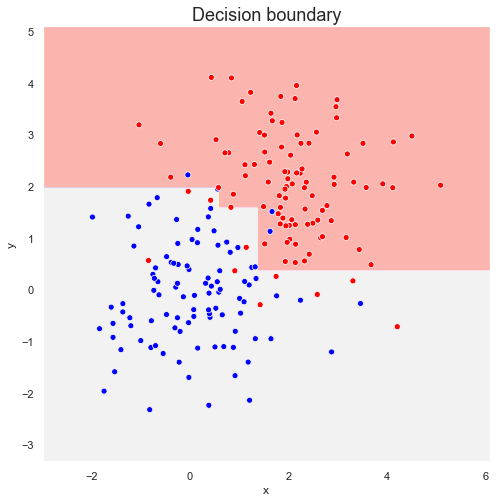

In [215]:
plt.figure(figsize=(8,8))
decision_plot(n,Ada)
sns.scatterplot(data=data,x='x',y='y',hue='target',legend=False,palette=['red','blue'])
plt.title("Decision boundary",fontsize=18)
plt.savefig('../joaomvg.github.io/content/images/adaboost50.png')
plt.show()

In [216]:
Ada=AdaBoostClassifier(algorithm='SAMME')
Ada.fit(n,yr)

AdaBoostClassifier(algorithm='SAMME')

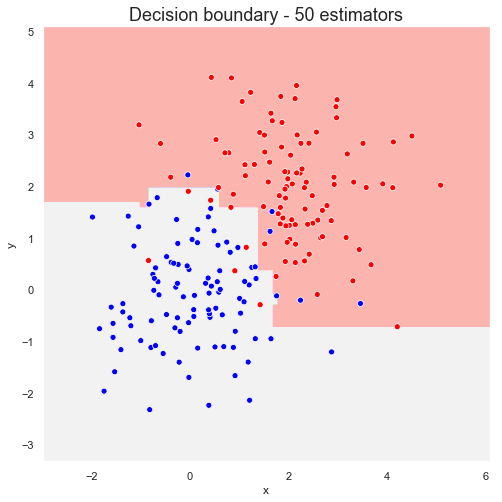

In [218]:
plt.figure(figsize=(8,8))
decision_plot(n,Ada)
sns.scatterplot(data=data,x='x',y='y',hue='target',legend=False,palette=['red','blue'])
plt.title("Decision boundary - 50 estimators",fontsize=18)
plt.savefig('../joaomvg.github.io/content/images/adaboost_.png')
plt.show()

# From scratch

In [32]:
class node:
    def __init__(self,alpha=None,tree=None):
        self.tree=tree
        self.alpha=alpha
        self.next=None
        
    def insert(self,alpha,tree):
        if self.next is None:
            self.next=node(alpha,tree)
        else:
            return self.next.insert(alpha,tree)
    
class AdaBoost:
    def __init__(self,T):
        self.T=T
        self.head=node(alpha=1,tree=DecisionTreeClassifier(max_depth=1))
    
    def step(self,ypred,y,sample_weight):
        error=1-accuracy_score(y,ypred,sample_weight=sample_weight)
        if error==1.0:
            return 'stop'
        else:
            alpha=0.5*np.log((1-error)/error)
            sample_weight=sample_weight*np.exp(-y*ypred*alpha)
            sample_weight=sample_weight/sample_weight.sum()

            return alpha, sample_weight
    
    def fit(self,x,y):
        
        sample_weight=np.ones(x.shape[0])
        self.head.tree.fit(x,y)
        ypred=self.head.tree.predict(x)
        alpha, sample_weight=self.step(ypred,y,sample_weight)
        self.head.alpha=alpha
        for i in range(1,self.T):
            tree=DecisionTreeClassifier(max_depth=1)
            tree.fit(x,y,sample_weight=sample_weight)
            ypred=tree.predict(x)
            alpha, sample_weight=self.step(ypred,y,sample_weight)
            self.head.insert(alpha,tree)
    
    def read(self,node,x):
        ypred=node.tree.predict(x)
        ypred=node.alpha*ypred
        if node.next is None:
            return ypred
        else:
            return ypred+self.read(node.next,x)
             
    def predict(self,x):
        ypred=self.read(self.head,x)
        ypred=np.sign(ypred)
        return ypred

In [104]:
ada=AdaBoost(5)

In [105]:
ada.fit(n,yr)

In [106]:
accuracy_score(ada.predict(n),yr)

0.975

In [66]:
Ada.score(n,yr)

0.975